Load the Libraries


In [1505]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from numpy import sort
from tabulate import tabulate

# Visualization libraries and settings
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from wordcloud import WordCloud, STOPWORDS 
import seaborn as sns
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
#plt.rc('axes', titlesize=18)     # fontsize of the axes title
#plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
#plt.rc('legend', fontsize=13)    # legend fontsize
#plt.rc('font', size=10)          # controls default text sizes

# ML Models and metrics
from random import sample
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

**Reading the Dataset**


In [1506]:
df_rating = pd.read_csv('Corporate_Credit_Ratings.csv')

print("The Credit Rating dataset has", df_rating.shape[0], "records, each with",df_rating.shape[1],"attributes.")
df_rating.head()

The Credit Rating dataset has 7805 records, each with 25 attributes.


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,30/07/10,1056903,1,4941,"Transportation, Communications, Electric, Gas ...",AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,16/09/10,8670,1,7374,Services,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,23/11/10,8858,1,5065,Wholesale Trade,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,29/06/10,1035201,1,4941,"Transportation, Communications, Electric, Gas ...",CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,14/07/10,721371,1,5122,Wholesale Trade,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


Initial view of the dataset and considering the domain of credit ratings, we can quickly conclude on which of the above columns can be dropped to ensure we have a good clean dataset to do further analysis on.

1. Columns to be dropped: CIK, Ticker, SIC Code
2. To check further: Rating Date (would like to check if there is any significance to the Rating classification)
3. We can drop the Corporation column as well, but we will keep it so we can create a wordcloud and classify them into Risk profiles.


In [1507]:
# We will drop CIK, Ticker and SIC Code columns
df_rating.drop(['CIK','Ticker','SIC Code'], axis=1, inplace=True)
df_rating.head()

,Rating Agency,Corporation,Rating,Rating Date,Binary Rating,Sector,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,30/07/10,1,"Transportation, Communications, Electric, Gas ...",1.1507,0.4551,0.8847,77.6230,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,16/09/10,1,Services,1.1129,0.0072,0.0073,43.6619,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,23/11/10,1,Wholesale Trade,1.9276,0.2924,0.4255,11.9008,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,29/06/10,1,"Transportation, Communications, Electric, Gas ...",0.8358,0.4708,0.9491,64.5096,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,14/07/10,1,Wholesale Trade,1.2931,0.2644,0.4036,3.8385,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


**Understanding and exploring the columns and dataset better**


In [1508]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rating Agency                  7805 non-null   object 
 1   Corporation                    7805 non-null   object 
 2   Rating                         7805 non-null   object 
 3   Rating Date                    7805 non-null   object 
 4   Binary Rating                  7805 non-null   int64  
 5   Sector                         7805 non-null   object 
 6   Current Ratio                  7805 non-null   float64
 7   Long-term Debt / Capital       7805 non-null   float64
 8   Debt/Equity Ratio              7805 non-null   float64
 9   Gross Margin                   7805 non-null   float64
 10  Operating Margin               7805 non-null   float64
 11  EBIT Margin                    7805 non-null   float64
 12  EBITDA Margin                  7805 non-null   f

In [1509]:
# Check for null
df_rating.isnull().sum()

Rating Agency                    0
Corporation                      0
Rating                           0
Rating Date                      0
Binary Rating                    0
Sector                           0
Current Ratio                    0
Long-term Debt / Capital         0
Debt/Equity Ratio                0
Gross Margin                     0
Operating Margin                 0
EBIT Margin                      0
EBITDA Margin                    0
Pre-Tax Profit Margin            0
Net Profit Margin                0
Asset Turnover                   0
ROE - Return On Equity           0
Return On Tangible Equity        0
ROA - Return On Assets           0
ROI - Return On Investment       0
Operating Cash Flow Per Share    0
Free Cash Flow Per Share         0
dtype: int64

There are no NULL values to deal with. We will take a look at some plots and explore any areas to treat/process further. We clearly see 2 kinds of variables:

1. Categorical Variables: 
    - Rating Agency
    - Rating (Target Variable for Classification)
    - Binary Rating (1: Investment Grade OR 0 - Junk/Speculative Grade)
    - Sector

2. Numerical Variables:
    - All the financial ratio columns that would be the key parameters to drive Rating classification

We will plot the categorical variables just to get a sense of the distribution.


In [1510]:
df_rating_cat = pd.DataFrame(df_rating, columns=['Rating Agency','Rating', 'Binary Rating', 'Sector'])
df_rating_cat.columns
df_rating_cat.shape


(7805, 4)

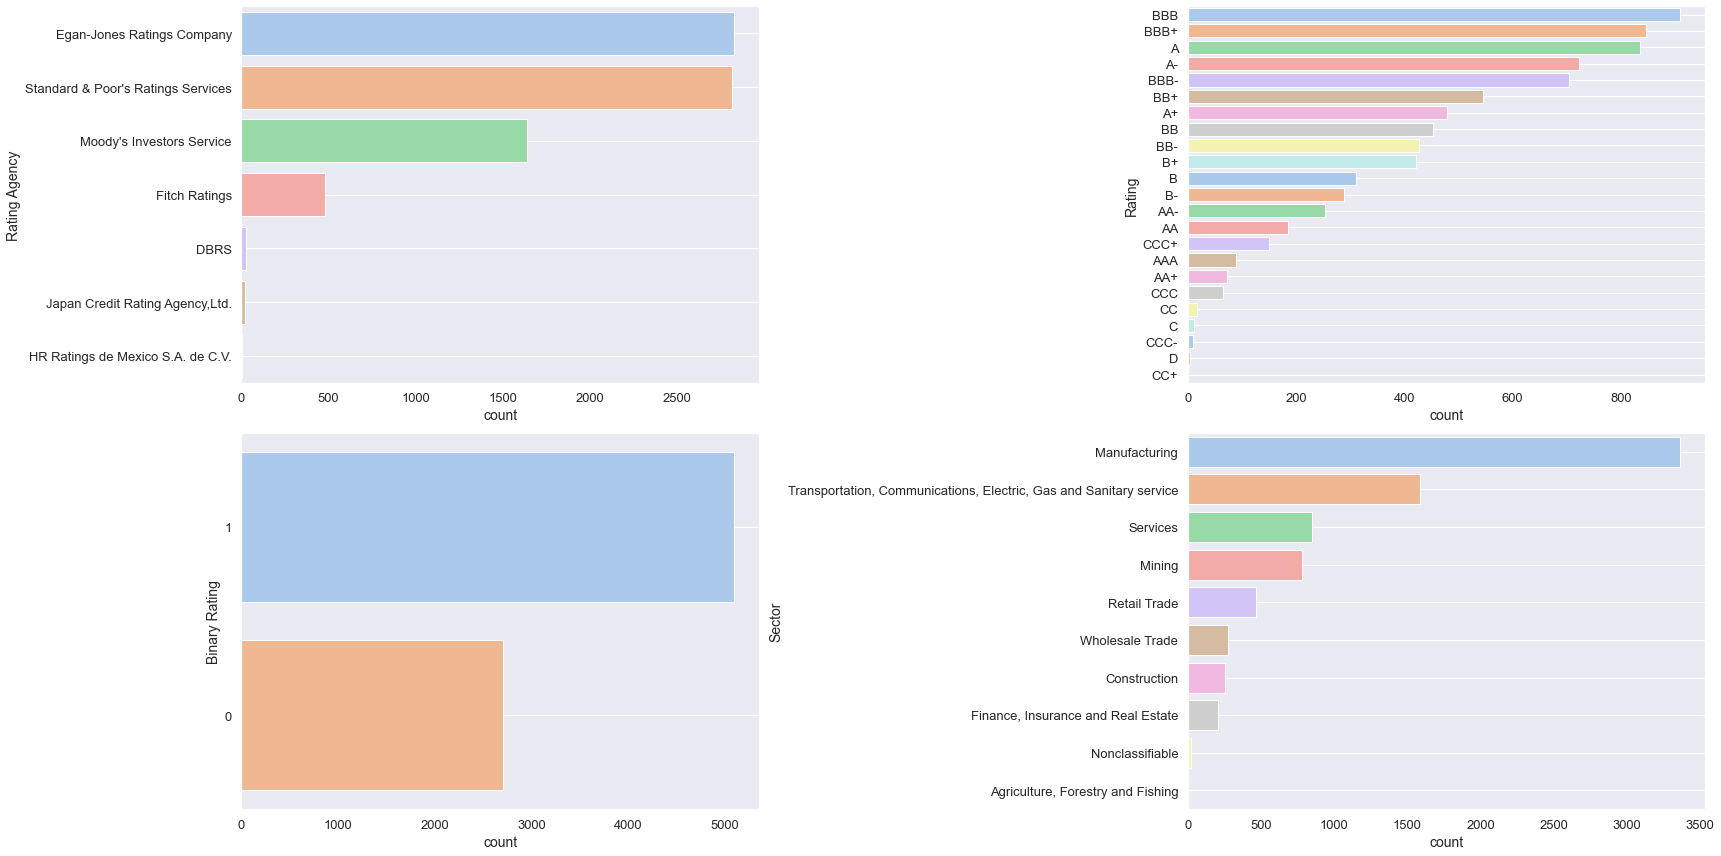

In [1511]:
plt.figure(figsize=(24,12), tight_layout=True)

for i, col in enumerate(list(df_rating_cat)):
    plt.subplot(2,2,i+1)
    sns.countplot(y=df_rating_cat[col], label='data', palette="pastel", order=df_rating_cat[col].value_counts().index)
    plt.grid()

**Rating Agency**

Egan-Jones, Standard & Poor (S&P), Moody's and Fitch control approximately 95% of the credit ratings business. 

**Binary Rating**

The 1s (Investment Grade) are almost 50% more than the 0s (Junk Grade). 

**Sector**

1. Manufacturing, Transport (& Utilities), Services and Mining sectors are covered mostly in this dataset
2. Trade, Construction, Financial services account for the remaining with very few to 0 in the non-classifiable and Agro sectors (can be ignored) 

Sectors are mapped at the highest order of the SIC Code classification methodology. More fine-grained mapping can be done based on the sub-sectors, but is not needed for now as the Ratings are largely driven by the financials of the company. The sector might get impacted at the macro level for a given economic situation, but for the purposes of this analysis, we will consider minimal impact to Ratings because of the sector.

**Ratings**

There are too many categories of ratings. Some ratings such as CC+, CCC-, B-, etc. that are sub-ratings to the primary ones. We will consolidate those to be in line with how the top 3-4 credit rating agencies follow as per this link:https://www.investopedia.com/terms/c/corporate-credit-rating.asp. We will clean this up in the subsequent steps and rationalize the ratings.

**Analysis of Rating Labels**

We are looking at ordinal labels for the Rating Classifications - this means that there is a scale for the ratings which represents most secure (Triple AAA) to the least secure (C) and finally to Default (D - indicates the company will likely default on its creditors). We will have a first look at the how many ratings we have of each in the dataset. We already know from the previous plot that there are a lot of sub-ratins as well. We will treat those subsequently.

In [1512]:
df_rating.Rating.value_counts()


BBB     910
BBB+    846
A       836
A-      722
BBB-    705
BB+     545
A+      478
BB      453
BB-     427
B+      422
B       310
B-      288
AA-     254
AA      185
CCC+    151
AAA      90
AA+      73
CCC      65
CC       18
C        11
CCC-     10
D         5
CC+       1
Name: Rating, dtype: int64

We observe that the dataset is very imbalanced. There are 910 BBBs but only 1 CC+ and 5 Ds. Since we have 7 rating agencies (actually 3 since they control most of the ratings), we will consolidate and simplify them according to the table at Investopedia link provided above. We will then classify according to the grading risk and not the count.

<table>
<tbody>
<tr>
<td><b>Moody's<b></td>
<td><b>Standard &amp; Poor's<b></td>
<td><b>Fitch<b></td>
<td><b>Grade<b></td>
<td><b>Risk<b></td>
</tr>
<tr>
<td>Aaa</td>
<td>AAA</td>
<td>AAA</td>
<td>Investment</td>
<td>Lowest Risk</td>
</tr>
<tr>
<td>Aa</td>
<td>AA</td>
<td>AA</td>
<td>Investment</td>
<td>Low Risk</td>
</tr>
<tr>
<td>A</td>
<td>A</td>
<td>A</td>
<td>Investment</td>
<td>Low Risk</td>
</tr>
<tr>
<td>Baa</td>
<td>BBB</td>
<td>BBB</td>
<td>Investment</td>
<td>Medium Risk</td>
</tr>
<tr>
<td>Ba, B</td>
<td>BB, B</td>
<td>BB, B</td>
<td>Junk</td>
<td>High Risk</td>
</tr>
<tr>
<td>Caa/Ca</td>
<td>CCC/CC/C</td>
<td>CCC/CC/C</td>
<td>Junk</td>
<td>Highest Risk</td>
</tr>
<tr>
<td>C</td>
<td>D</td>
<td>D</td>
<td>Junk</td>
<td>In Default</td>
</tr>
</tbody>
</table>

In [1513]:
df_rating['Rating'] = df_rating['Rating'].str.replace('+','').str.replace('-','')
df_rating['Rating'].value_counts()

BBB    2461
A      2036
BB     1425
B      1020
AA      512
CCC     226
AAA      90
CC       19
C        11
D         5
Name: Rating, dtype: int64

We have simplified the Rating Labels to the core set as per the Ratings classification above. We will now replace these ratings with the Risk Grades - to do so, we will use a dictionary.


In [1514]:
df_rating.shape


(7805, 22)

In [1515]:
ratings_dict = { 'AAA':'Lowest Risk',
                  'AA':'Low Risk',
                  'A':'Low Risk',
                  'BBB':'Medium Risk',
                  'BB':'High Risk',
                  'B':'High Risk',
                  'CCC':'Highest Risk',
                  'CC':'Highest Risk',
                  'C':'Close to Default',
                  'D':'In Default'}

df_rating.Rating = df_rating.Rating.map(ratings_dict)

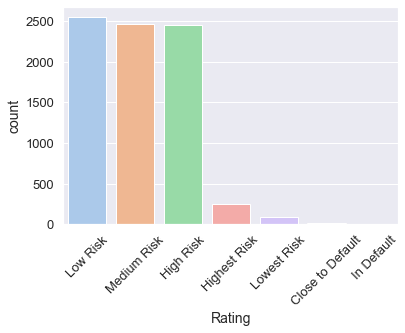

In [1516]:
chart = sns.countplot(x='Rating', data=df_rating, palette='pastel', order=df_rating['Rating'].value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

There are close to 0 observations for "Close to Default" and "In Default" categories. We will not remove them from the dataset. 


In [1517]:
df_rating.shape


(7805, 22)

**DESCRIPTIVE STATISTICS**

We will now explore the dataset using the common .describe method to look at the quantitative stats of the numerical features. In addition, we will use a Pandas library "pandas_profiling" that reduces the entire analysis of the dataset to a single line of code with some basic visualizations. We will use that as well to see if it gives a good overview of the data.

In [1518]:
from pandas_profiling import ProfileReport
DataProfile = ProfileReport(df_rating, title = "Credit Ratings Data Profile Report", explorative = True, minimal = True)
DataProfile.to_file(output_file = "DataProfile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 389.05it/s]


In [1519]:
df_rating.describe()

,Binary Rating,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000
mean,0.653299,1.926313,0.452804,0.177349,42.433909,11.531612,11.582683,20.071493,8.659944,5.995566,0.849843,15.950507,21.481589,4.575705,7.076084,0.479756,0.119491
std,0.475950,1.921651,2.629158,34.456334,23.742020,25.469044,25.483934,24.380407,27.866408,24.055577,0.696204,230.592526,462.734075,9.229899,24.382027,6.050626,7.253660
min,0.000000,0.174900,-86.363600,-1473.098000,-87.684000,-461.787800,-461.787800,-360.816900,-476.010000,-414.824800,0.068400,-11258.210000,-14023.260000,-226.442500,-745.454500,-91.330200,-130.665800
25%,0.000000,1.077300,0.286500,0.419700,22.453900,6.098200,6.181100,11.162100,4.008700,2.637100,0.399500,6.022800,-12.233900,2.391900,3.692600,-0.448500,-0.723700
50%,1.000000,1.496800,0.427200,0.752800,39.635400,12.120100,12.155800,18.304500,9.705100,6.938900,0.661200,12.500000,10.564100,4.767500,7.440800,0.237800,0.133500
75%,1.000000,2.161000,0.542200,1.211600,59.641700,19.464600,19.539900,30.661600,16.676900,12.366700,1.038800,20.515700,26.894100,7.881300,12.515100,1.088800,0.997800
max,1.000000,34.076800,171.500000,194.375000,100.000000,93.993000,93.993000,286.493500,221.289400,219.390300,8.503900,7038.461000,9882.979000,114.716900,466.666700,282.192100,107.737700


In [1520]:
df_rating.shape


(7805, 22)

In [1521]:
# Creating a Numerical dataframe for further exploration of the numerical data (ignoring the Binary Ratings column as it is not a financial ratio feature)
df_rating_num = df_rating.select_dtypes("float64")
df_rating.dtypes

Rating Agency                     object
Corporation                       object
Rating                            object
Rating Date                       object
Binary Rating                      int64
Sector                            object
Current Ratio                    float64
Long-term Debt / Capital         float64
Debt/Equity Ratio                float64
Gross Margin                     float64
Operating Margin                 float64
EBIT Margin                      float64
EBITDA Margin                    float64
Pre-Tax Profit Margin            float64
Net Profit Margin                float64
Asset Turnover                   float64
ROE - Return On Equity           float64
Return On Tangible Equity        float64
ROA - Return On Assets           float64
ROI - Return On Investment       float64
Operating Cash Flow Per Share    float64
Free Cash Flow Per Share         float64
dtype: object

In [1522]:
df_rating_num.shape


(7805, 16)

<AxesSubplot:>

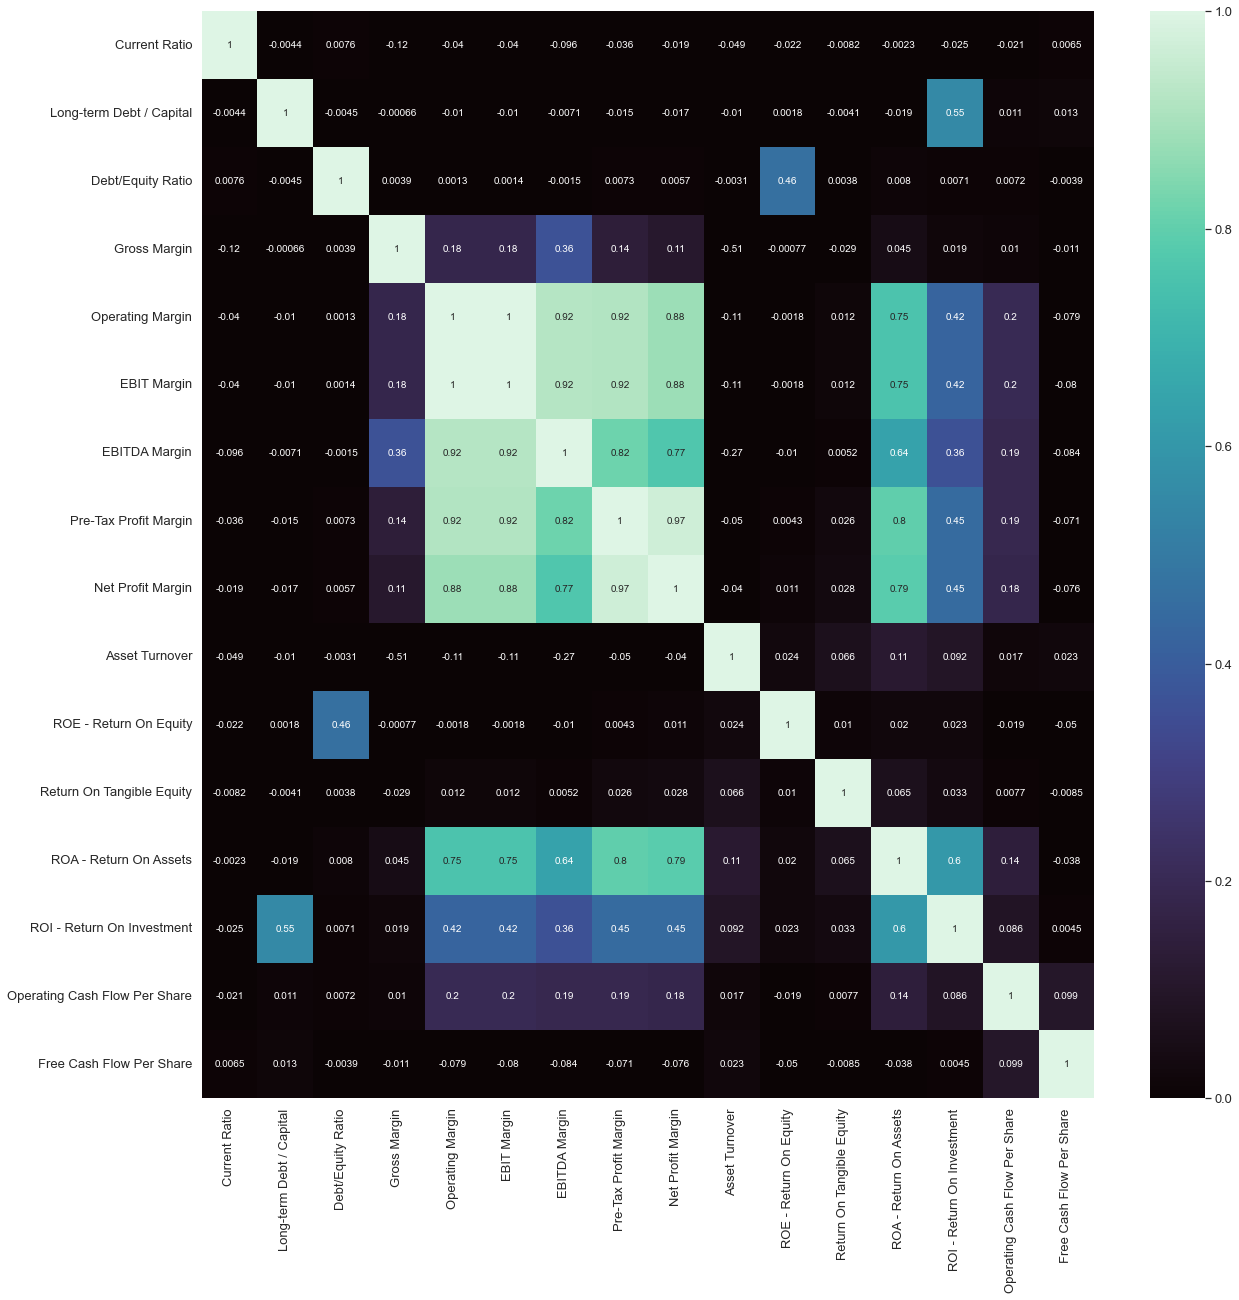

In [1523]:
# Plotting a heatmap plot to get an initial sense of the features that impact Rating
plt.figure(figsize=(20,20))
sns.heatmap(df_rating_num.corr(), cmap='mako', annot=True, vmin=0, vmax=1)

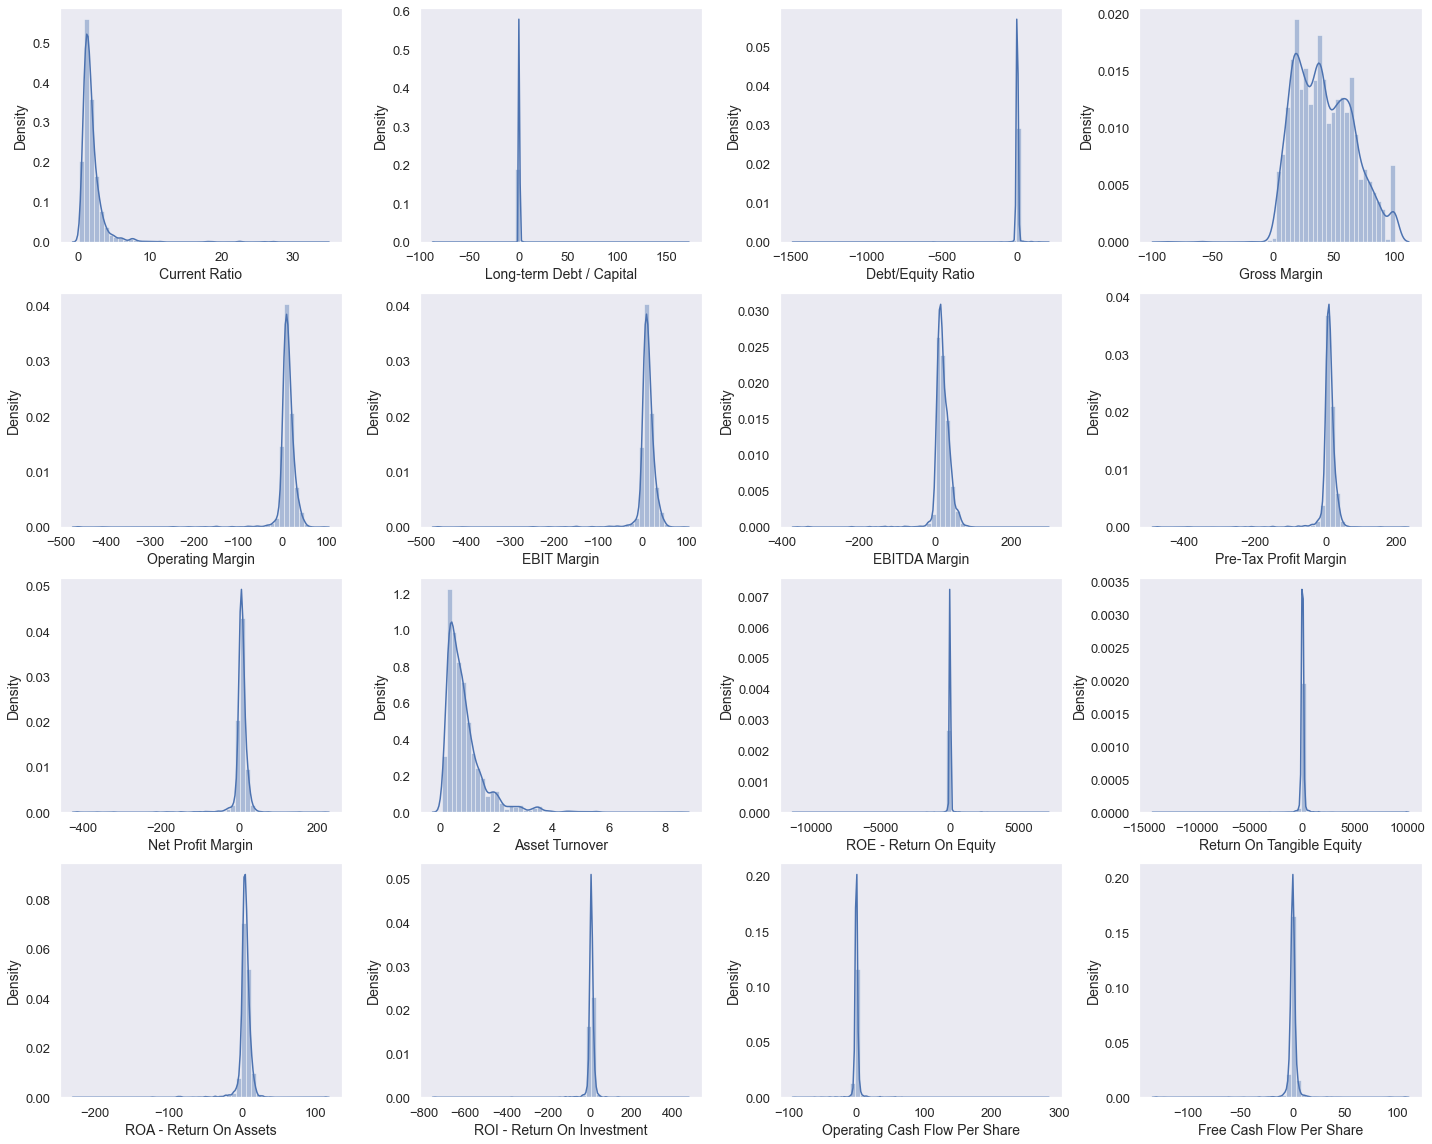

In [1524]:
plt.figure(figsize=(20,16))

for i, col in enumerate(list(df_rating_num)):
    plt.subplot(4,4,i+1)
    sns.distplot(df_rating_num[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()


The data seems to have outliers for some of the numerical features such as Current Ratio, Asset Turnover. Let's use the .skew function for all the columns - it should return a value between 0 and 1 if a column is normally distributed.

In [1525]:
df_rating_num.skew(axis=0)


Current Ratio                     7.260351
Long-term Debt / Capital         21.595244
Debt/Equity Ratio               -27.879850
Gross Margin                      0.352416
Operating Margin                 -9.754324
EBIT Margin                      -9.739402
EBITDA Margin                    -5.903670
Pre-Tax Profit Margin            -8.655398
Net Profit Margin                -8.689543
Asset Turnover                    2.770181
ROE - Return On Equity           -9.281851
Return On Tangible Equity         8.950553
ROA - Return On Assets           -5.268877
ROI - Return On Investment      -14.827059
Operating Cash Flow Per Share    13.536540
Free Cash Flow Per Share         -2.547216
dtype: float64

As we can see, almost all the columns are extremely skewed. But we are not sure what percent of the data is causing this skewness. Let's identify the proportion of outliers in each column. Definition of outlier = above or below 1.5 X IQR.

In [1526]:
# Loop to calculate proportion of outliers in each of the numerical columns
for c in df_rating_num:
    q1 = df_rating_num[c].quantile(0.25)
    q3 = df_rating_num[c].quantile(0.75)
    iqr = q3 - q1
    fence_low = q3 - 1.5*iqr
    fence_high = q1 + 1.5*iqr
    lower_out = len(df_rating_num.loc[(df_rating_num[c] < fence_low), c])
    upper_out = len(df_rating_num.loc[(df_rating_num[c] > fence_high), c])
    outlier_count = lower_out + upper_out
    prop_outlier = outlier_count/len(df_rating_num)
    print(c, ": "+"{:.2%}".format(prop_outlier))


Current Ratio : 17.19%
Long-term Debt / Capital : 21.82%
Debt/Equity Ratio : 20.65%
Gross Margin : 9.12%
Operating Margin : 19.68%
EBIT Margin : 19.85%
EBITDA Margin : 15.63%
Pre-Tax Profit Margin : 22.10%
Net Profit Margin : 22.56%
Asset Turnover : 15.03%
ROE - Return On Equity : 26.11%
Return On Tangible Equity : 28.08%
ROA - Return On Assets : 23.66%
ROI - Return On Investment : 22.77%
Operating Cash Flow Per Share : 31.01%
Free Cash Flow Per Share : 30.31%


Most of the columns have a significant proportion of outliers. But it still does not tell us the distribution of rows across the dataset which are contributing to the outliers. If we are able to get that information, we can then take an informed decision on how to treat them. We will create a new dataframe for this purpose - we will make a copy of our dataframe and do the outliers analysis on that.

In [1527]:
# Making a copy of the Numerical dataframe for further analysis
df_rating_out = df_rating_num.copy()

for c in df_rating_out:
    
    q1 = df_rating_out[c].quantile(0.25)
    q3 = df_rating_out[c].quantile(0.75)
    iqr = q3 - q1 
    fence_low  = q3 - 1.5*iqr
    fence_high = q1 + 1.5*iqr
    
    for i in range(len(df_rating_out)):
        # If outlier
        if df_rating.loc[i,c] < fence_low or df_rating.loc[i,c] > fence_high:
            df_rating_out.loc[i,c] = 1
        else: # Not an Outlier
            df_rating_out.loc[i,c] = 0

df_rating_out.head()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [1528]:
# Add a column to the dataframe to get the overall sum of the 1s and 0s for each row
df_rating_out['Total'] = df_rating_out.sum(axis=1)
df_rating_out.head()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share,Total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0


<AxesSubplot:>

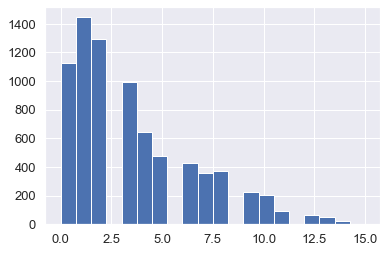

In [1529]:
# Create a histogram of the "Total" column to check on frequency of 1s and 0s against the number of rows
df_rating_out.Total.hist(bins=20)


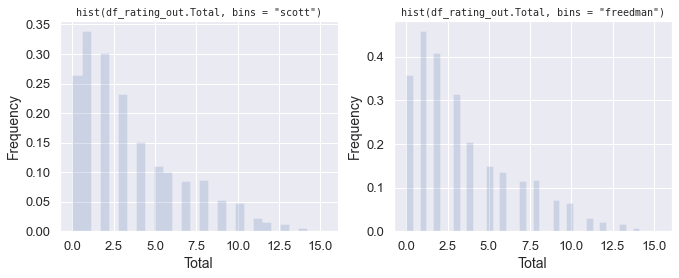

In [1530]:
# Utilizing the astropy visualization library to check on the histogram for outliers and interpret it better
from astropy.visualization import hist
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.subplots_adjust(left = 0.1, right = 0.95, bottom = 0.15)

for i, bins in enumerate(['scott', 'freedman']):
    hist(df_rating_out['Total'], bins = bins, ax = ax[i], histtype = 'stepfilled',
        alpha = 0.2, density = True)
    ax[i].set_xlabel('Total')
    ax[i].set_ylabel('Frequency')
    ax[i].set_title(f'hist(df_rating_out.Total, bins = "{bins}")',
                    fontdict = dict(family='monospace'),
                    fontsize = 10)
    
#ax = sns.histplot(df_rating_out['Total'], bins=20)
#df_rating_out.Total.hist(bins='scott', histtype='stepfilled', density=True)
#sns.countplot(data=df_rating_out, x='Total')
#sns.histplot(data=df_rating_out, x='Total', bins=20)

Interestingly, there are only about 1000 rows that do not have outliers. Most other rows have outliers and hence, we will keep them as is - they may provide some interesting results in the classification prediction stages.

In order to understand the concept of outliers better and plotting histograms to ensure we treat them correctly, I went through this link (<href>https://docs.astropy.org/en/latest/visualization/histogram.html#normal-reference-rules<href>) to see how can I capture the data correctly. The other plots were not clear. 

We will try to re-shape the data (normalization) to see if we can treat the outliers correctly and ensure their negative impact is reduced. To implement non-linear transformations, Sklearn offers a PowerTransformer class (which uses logarithmic functions under the hood) that helps minimize skewness and map any distribution to a normal one as close as possible. It is advised that whenever faced with a skewed distribution, use the PowerTransformer class. Our dataset seems to be a good choice for this. We will attempt this and see if it works.


In [1531]:
# Applying normalization & transformation to see if it reduces the impact of outliers
from sklearn.preprocessing import PowerTransformer

# Init
pt = PowerTransformer()

df_rating_num = pd.DataFrame(pt.fit_transform(df_rating_num), columns=df_rating_num.columns)
df_rating_num.columns


Index(['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
       'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object')

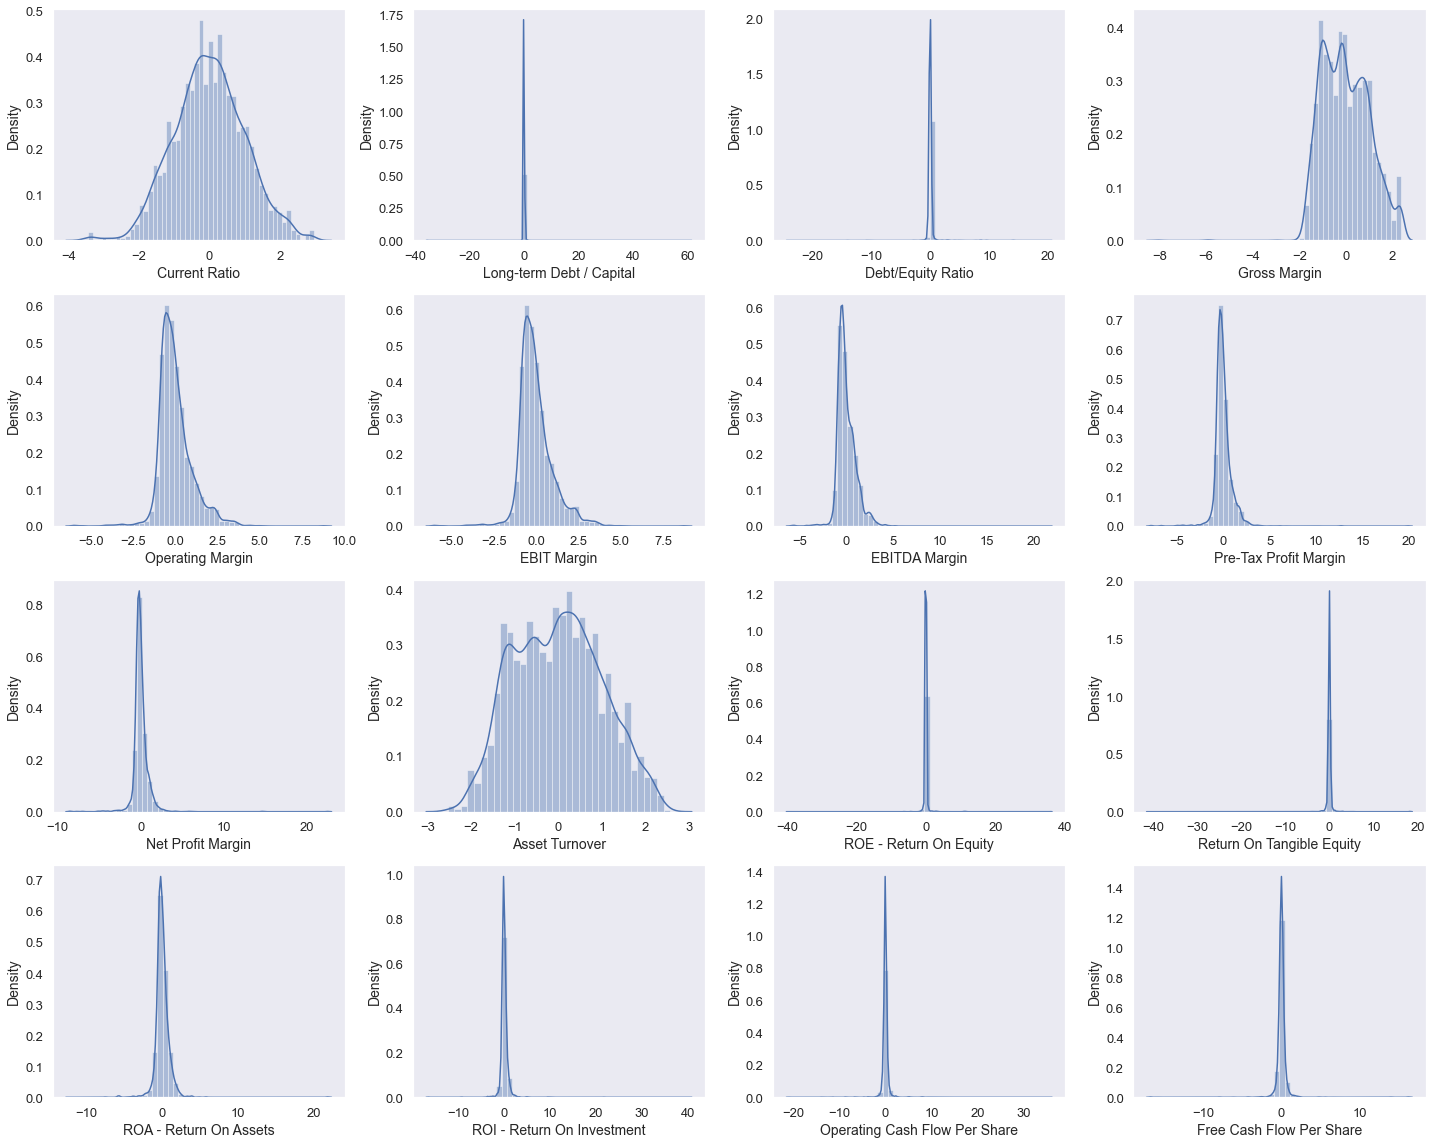

In [1532]:
# Check the distribution plots again for any effects of the transformation
plt.figure(figsize=(20,16))

for i, col in enumerate(list(df_rating_num)):
    plt.subplot(4,4,i+1)
    sns.distplot(df_rating_num[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

Some of the distributions above have changed to a more normalized one - such as for Current Ratio, Gross Margin, Asset Turnover, EBIT margin, EBIDTA Margin.

We will also check on the proportion of outliers to validate the visualization on outliers.


In [1533]:
# Check to see if there are any significant changes to the proportion of outliers
for c in df_rating_num:
    q1 = df_rating_num[c].quantile(0.25)
    q3 = df_rating_num[c].quantile(0.75)
    iqr = q3 - q1
    fence_low = q3 - 1.5*iqr
    fence_high = q1 + 1.5*iqr
    lower_out = len(df_rating_num.loc[(df_rating_num[c] < fence_low), c])
    upper_out = len(df_rating_num.loc[(df_rating_num[c] > fence_high), c])
    outlier_count = lower_out + upper_out
    prop_outlier = outlier_count/len(df_rating_num)
    print(c, ": "+"{:.2%}".format(prop_outlier))

Current Ratio : 19.06%
Long-term Debt / Capital : 21.77%
Debt/Equity Ratio : 20.14%
Gross Margin : 9.44%
Operating Margin : 18.33%
EBIT Margin : 18.39%
EBITDA Margin : 15.35%
Pre-Tax Profit Margin : 20.55%
Net Profit Margin : 21.06%
Asset Turnover : 12.83%
ROE - Return On Equity : 26.29%
Return On Tangible Equity : 28.84%
ROA - Return On Assets : 22.66%
ROI - Return On Investment : 21.32%
Operating Cash Flow Per Share : 31.16%
Free Cash Flow Per Share : 30.24%


The Proportion of outliers for each of the numerical column has not significantly reduced after applying the Power Transformation method but it has allowed us to normalize the data. This should help reduce the impact of outliers when we get to the machine learning stage.

In [1534]:
# Checking the skew on the modified dataframe (ignoring the Binary Rating column)
df_rating_num.skew()

Current Ratio                     0.004974
Long-term Debt / Capital         12.365482
Debt/Equity Ratio                 2.000759
Gross Margin                      0.133950
Operating Margin                  0.867267
EBIT Margin                       0.871145
EBITDA Margin                     1.791731
Pre-Tax Profit Margin             3.859775
Net Profit Margin                 5.301802
Asset Turnover                    0.113992
ROE - Return On Equity            4.828151
Return On Tangible Equity        -2.597717
ROA - Return On Assets            4.743243
ROI - Return On Investment        9.636257
Operating Cash Flow Per Share     2.166022
Free Cash Flow Per Share          0.315960
dtype: float64

Although the proportion has not significantly changed, the Skewness has definitely reduced post the Power Transformation applied. And they do reflect the plots that are shown above. 


In [1535]:
df_rating.shape
df_rating_num.shape

(7805, 16)

**FEATURE SELECTION MODELS**


In [1536]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

In [1537]:
df_rating_cat.head()
#df_rating_cat.shape

df_rating_cat['Rating'] = df_rating_cat['Rating'].str.replace("+", "").str.replace("-", "")
df_rating_cat.head()


,Rating Agency,Rating,Binary Rating,Sector
0,Standard & Poor's Ratings Services,A,1,"Transportation, Communications, Electric, Gas ..."
1,Standard & Poor's Ratings Services,AAA,1,Services
2,Standard & Poor's Ratings Services,BBB,1,Wholesale Trade
3,Standard & Poor's Ratings Services,AA,1,"Transportation, Communications, Electric, Gas ..."
4,Standard & Poor's Ratings Services,A,1,Wholesale Trade


In [1538]:
# Mapping the Rating Labels from the Mapping Dictionary
df_rating_cat.Rating = df_rating_cat.Rating.map(ratings_dict)
df_rating_cat.head()

,Rating Agency,Rating,Binary Rating,Sector
0,Standard & Poor's Ratings Services,Low Risk,1,"Transportation, Communications, Electric, Gas ..."
1,Standard & Poor's Ratings Services,Lowest Risk,1,Services
2,Standard & Poor's Ratings Services,Medium Risk,1,Wholesale Trade
3,Standard & Poor's Ratings Services,Low Risk,1,"Transportation, Communications, Electric, Gas ..."
4,Standard & Poor's Ratings Services,Low Risk,1,Wholesale Trade


**FEATURE SELECTION: Univariate Method**


In [1539]:
# Create target variable DF and drop the column from the categorical dataframe
df_rating_y = df_rating_cat['Rating']
#df_rating_y.head()
# instantiate SelectKBest to determine 10 best features
best_features = SelectKBest(score_func=f_classif, k=10)
fit = best_features.fit(df_rating_num,df_rating_y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(df_rating_num.columns)

# concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature Name', 'Score'] # name output column
print(feature_scores.nlargest(10, 'Score'))


                     Feature Name       Score
12         ROA - Return On Assets  116.643931
7           Pre-Tax Profit Margin  111.421973
5                     EBIT Margin  106.637336
4                Operating Margin  105.504207
8               Net Profit Margin   86.706865
13     ROI - Return On Investment   53.936455
3                    Gross Margin   47.478491
6                   EBITDA Margin   43.465535
0                   Current Ratio   32.579291
14  Operating Cash Flow Per Share   12.641192


**FEATURE SELECTION: Correlation Method**

In [1540]:
#df_rating_y
df_rating_corr = pd.concat([df_rating_num, df_rating_y], axis=1)
df_rating_corr
#le = LabelEncoder()
#le.fit(df_rating_corr.Rating)
#df_rating_corr.Rating = le.transform(df_rating_corr.Rating)
#df_rating_corr

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share,Rating
0,-0.524712,0.002598,-0.046967,1.457024,0.419309,0.413748,0.408135,0.123501,-0.012396,-1.126358,-0.047883,-0.005294,-0.371747,-0.241435,0.285268,-0.044799,Low Risk
1,-0.590770,-0.168972,-0.092087,0.072560,0.449684,0.443996,0.103916,0.618629,0.371112,-1.061721,0.015090,0.077535,-0.123031,0.843141,-0.007296,0.017107,Lowest Risk
2,0.456867,-0.059602,-0.071193,-1.299040,-0.795689,-0.796602,-0.972660,-0.504947,-0.412256,1.832905,-0.023215,0.013270,-0.014153,0.060931,-1.541963,-1.009809,Medium Risk
3,-1.157566,0.008593,-0.043479,0.928832,0.330483,0.325291,0.344243,0.222871,0.037083,-1.227033,-0.041280,-0.002023,-0.369187,-0.205207,0.244052,-0.149982,Low Risk
4,-0.295310,-0.070320,-0.072317,-1.677134,-0.903445,-0.904031,-1.057270,-0.593760,-0.493789,2.351565,-0.034586,0.018868,-0.332994,-0.026824,0.281483,0.313557,Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7800,1.407353,0.022222,-0.039271,1.527605,0.967163,0.959275,0.692885,1.137153,0.882421,-0.501329,0.049914,0.177343,0.839240,0.369048,-0.275925,-0.202119,Medium Risk
7801,1.407353,0.022222,-0.039271,1.527605,0.967163,0.959275,0.692885,1.137153,0.882421,-0.501329,0.049914,0.177343,0.839240,0.369048,-0.275925,-0.202119,Medium Risk
7802,0.292239,-0.132028,-0.084988,0.511523,-0.019762,-0.023533,-0.446854,0.065859,-0.030535,0.350316,-0.031387,0.006211,0.339713,0.119353,-0.035122,0.149084,Highest Risk
7803,0.292239,-0.132028,-0.084988,0.511523,-0.019762,-0.023533,-0.446854,0.065859,-0.030535,0.350316,-0.031387,0.006211,0.339713,0.119353,-0.035122,0.149084,Highest Risk


<AxesSubplot:>

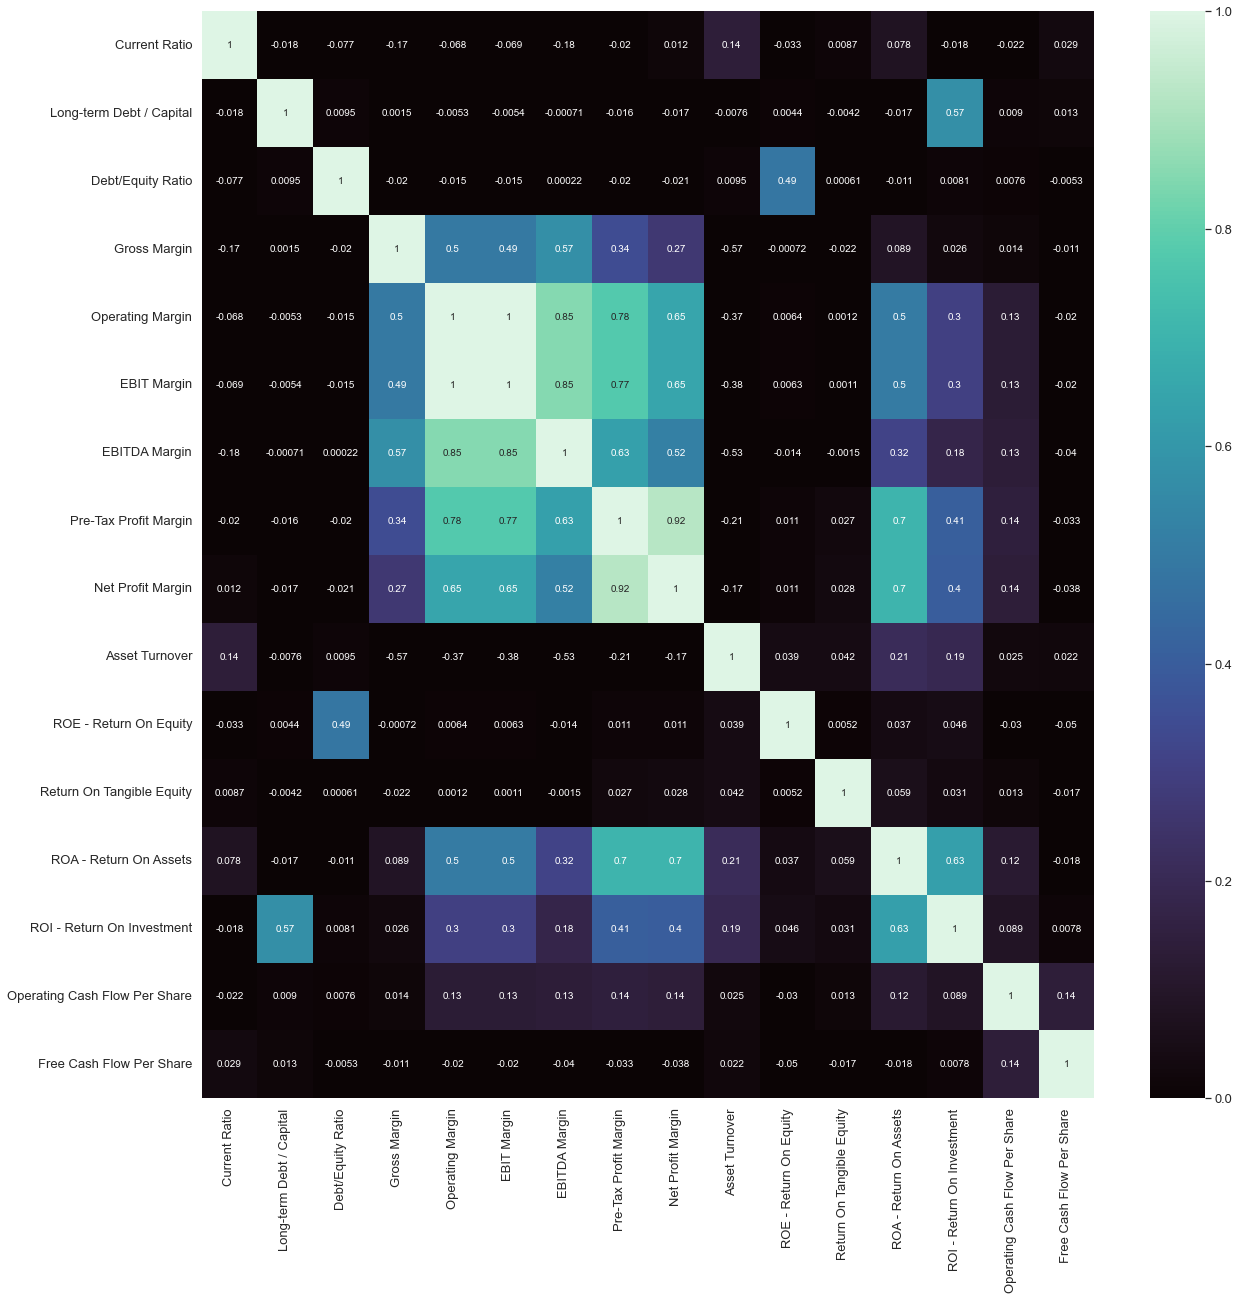

In [1541]:
#df_rating_corr = pd.concat([df_rating_num, df_rating_cat], axis=1)

#df_corr_rating = df_rating_corr.corr()['Rating'].sort_values(ascending=False)
#top_corr_features = df_corr_rating.index

#df_corr_rating.plot(kind='barh')
#plt.show()

plt.figure(figsize=(20,20))
sns.heatmap(df_rating_corr.corr(), cmap='mako', annot=True, vmin=0, vmax=1)

#df_rating_corr.corr()

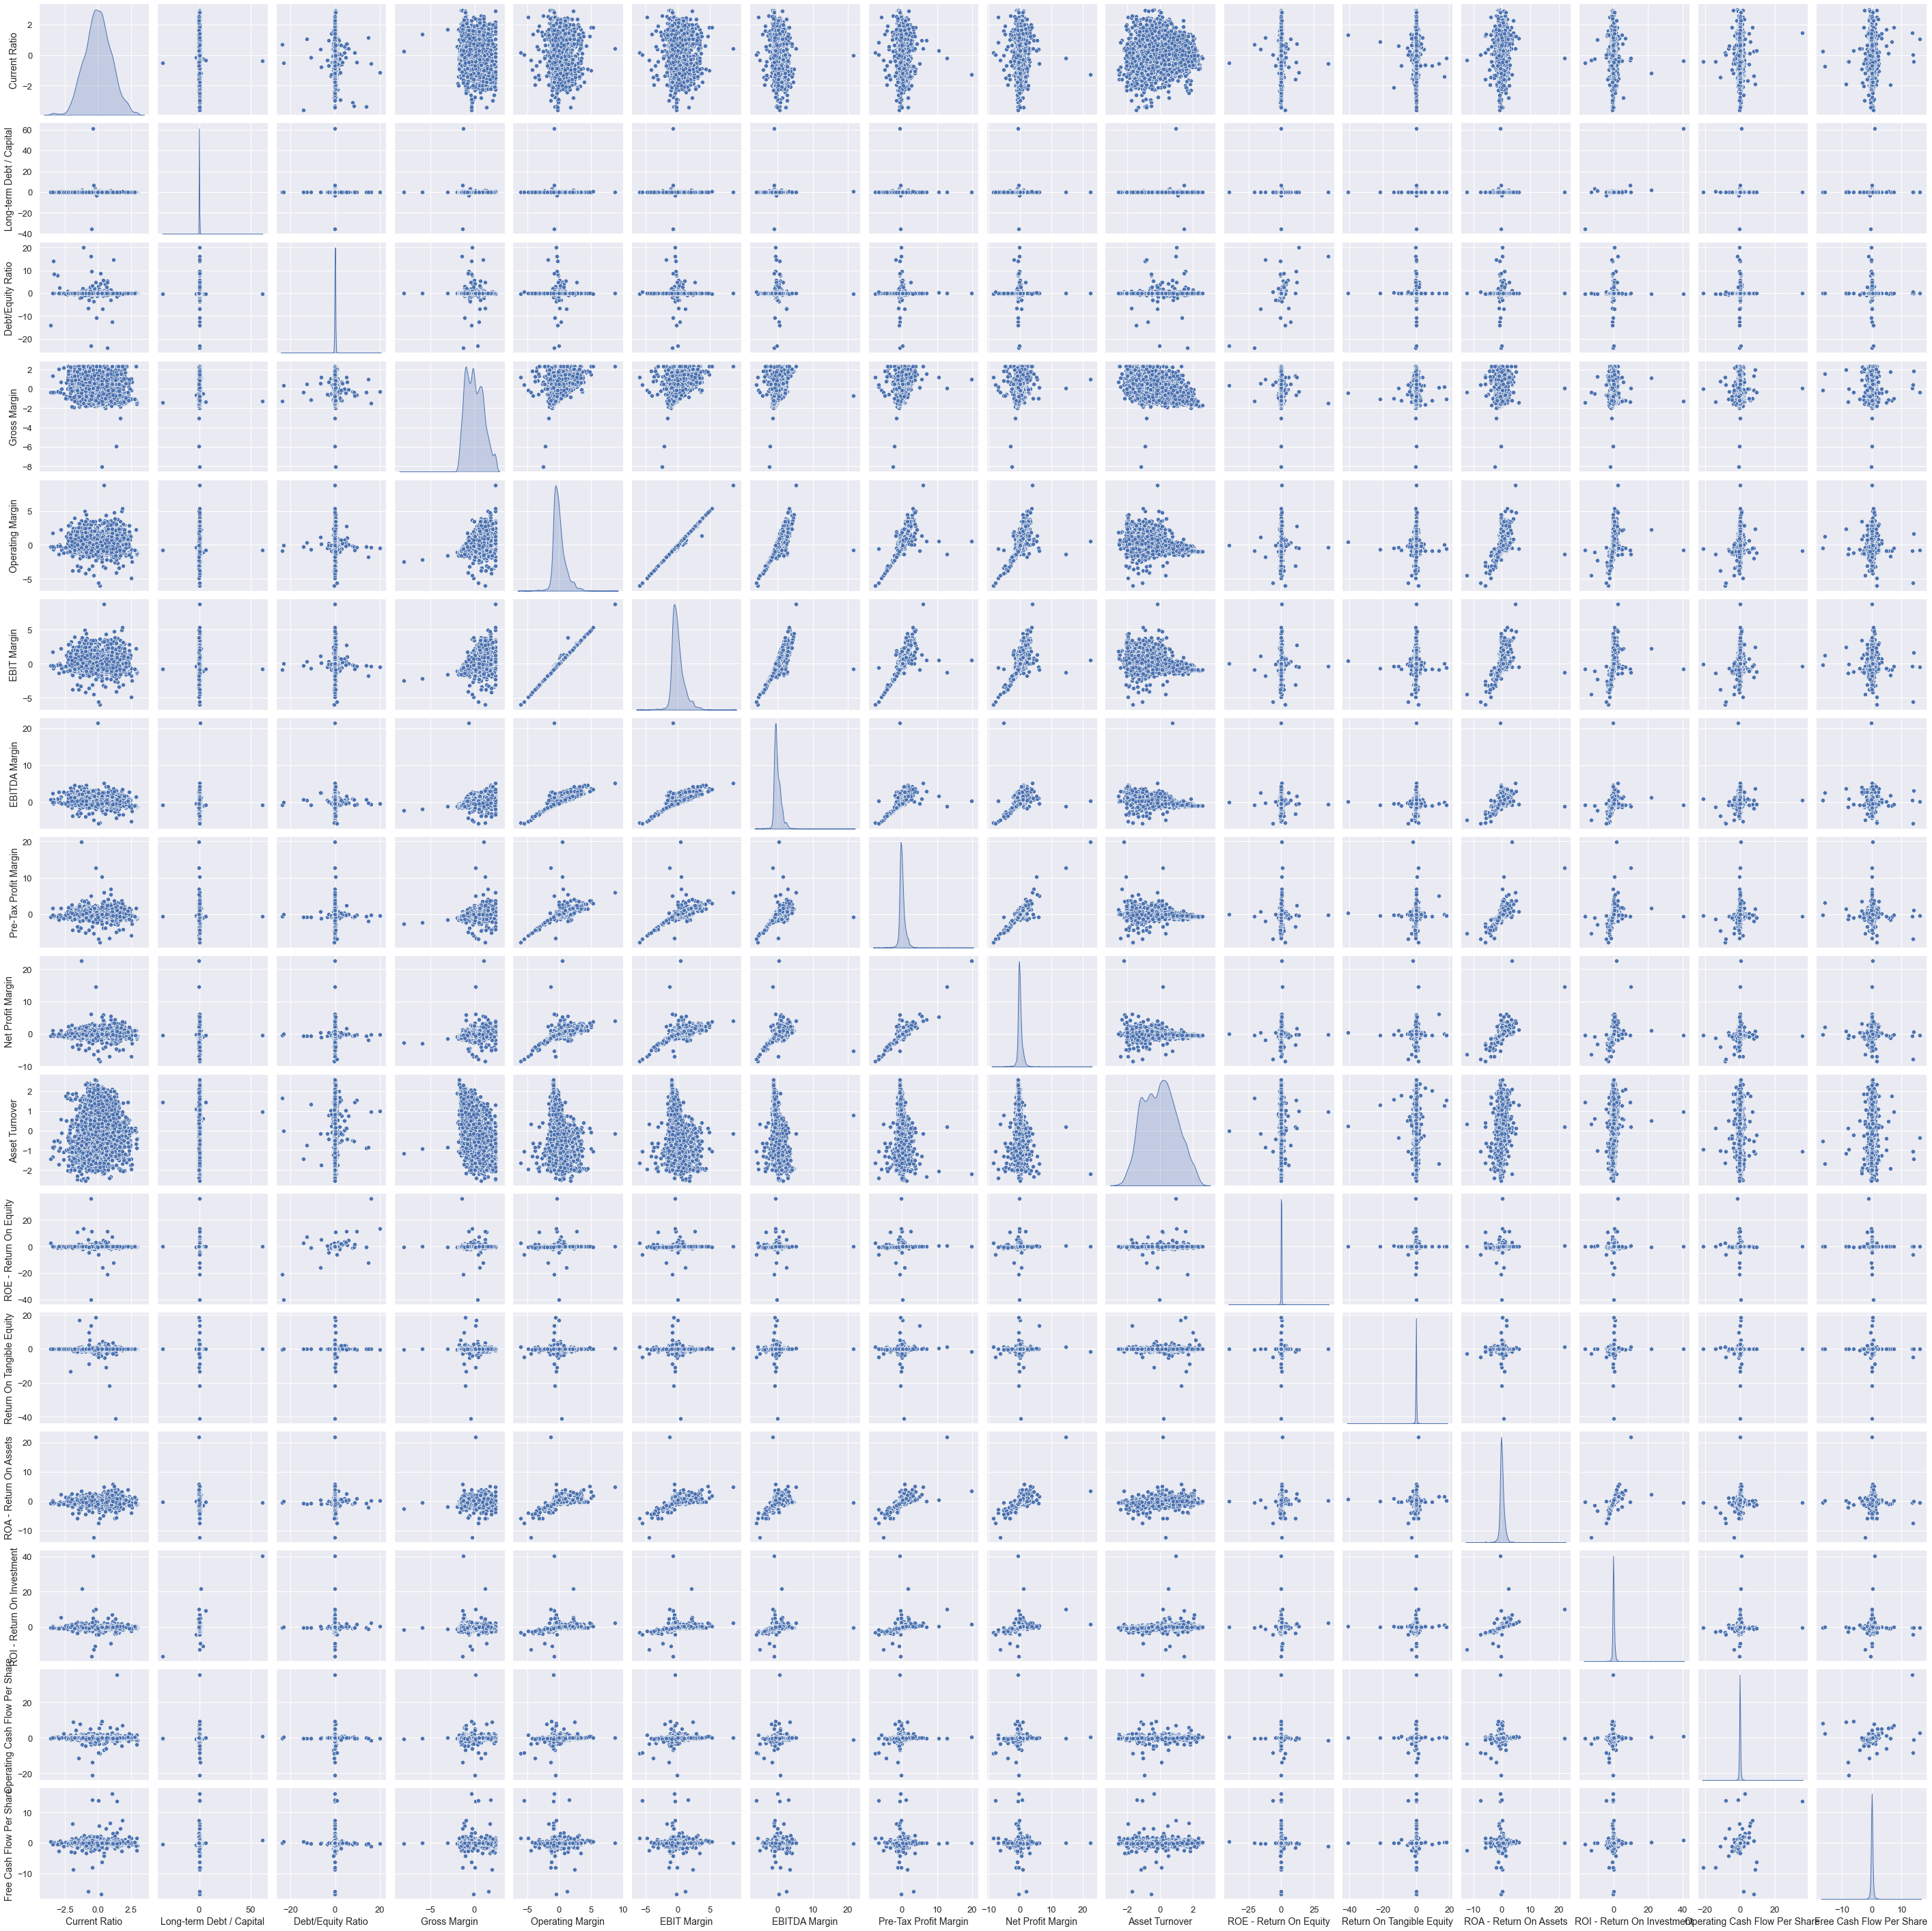

In [1542]:
# Plotting the correlations for a better visualization - we will look for linear relationships that depict correlation
sns.pairplot(df_rating_corr, diag_kind="kde")

**Interpretation**

As we can infer from the correlation table/heatmap/pairplot, - some of the financial features turn out to be highly correlated:

1) EBIT Margin & Operating Margin (1.0)
2) EBIDTA Margin & Operating Margin (0.92)
3) Operating Margin & Pre-tax Profit Margin (0.92)
4) Pre-tax profit margin & Net Profit Margin (0.97)

Basically, they provide similar information and hence, one of them would be enough as a possible indicator.

In all, using these 2 methods, we get a fair sense of the top predictors that influence Credit Rating classifications for a corporate. We will now get into the process of building models and comparing them to identify the best ML model that can be used.

**MODEL BUILDING**


Our objective here is to analyse if it is possible to predict the credit profile (Risk Rating) that a company will receive from a rating agency based on its financial indicators? If so, what are the those important features that can help predict a Risk Profile? Our method would be to test multiple algorithms, compare the accuracy and other metrics, and choose the winning model to fine tune the parameters before identifying the most important Predictors that would influence Ratings classification.

In the following steps we will perform the following:

* Prepare the dataset (encode categorical columns, split into train/test)
* Test a wide range of ML models (Tree-based, Probabilistic and so on).
* Compare the accuracy of all models and choose winning model based on highest accuracy.
* Tune hyperparameters to target a higher accuracy.
* Evaluate results based on Confusion Matrix (this is a classification problem)
* identify the most important features to predict the rating.

**Preparing the final dataset**

We will prepare the final dataset that we will use to run the ML models. For that, we need to encode the categorical columns as shown above, and concat this with the numerical dataframe that contains the financial feature columns.

In [1543]:
df_rating_cat = df_rating_cat.drop(columns=['Rating Agency', 'Binary Rating'], axis=1)
df_rating_cat.head()

#df_rating_final = pd.concat([df_rating_num, df_rating_y], axis=1)
#df_rating_final.head()
#df_rating_final


,Rating,Sector
0,Low Risk,"Transportation, Communications, Electric, Gas ..."
1,Lowest Risk,Services
2,Medium Risk,Wholesale Trade
3,Low Risk,"Transportation, Communications, Electric, Gas ..."
4,Low Risk,Wholesale Trade


In [1544]:
df_rating_cat.shape


(7805, 2)

In [1545]:
# Label Encoding the categorical columns
le = LabelEncoder()

# Encode Rating
le.fit(df_rating_cat.Rating)
df_rating_cat.Rating = le.transform(df_rating_cat.Rating)

# Encode Sector
le.fit(df_rating_cat.Sector)
df_rating_cat.Sector = le.transform(df_rating_cat.Sector)


In [1546]:
df_rating_final = pd.concat([df_rating_num, df_rating_cat], axis=1)
df_rating_final.head()


,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share,Rating,Sector
0,-0.524712,0.002598,-0.046967,1.457024,0.419309,0.413748,0.408135,0.123501,-0.012396,-1.126358,-0.047883,-0.005294,-0.371747,-0.241435,0.285268,-0.044799,4,8
1,-0.590770,-0.168972,-0.092087,0.072560,0.449684,0.443996,0.103916,0.618629,0.371112,-1.061721,0.015090,0.077535,-0.123031,0.843141,-0.007296,0.017107,5,7
2,0.456867,-0.059602,-0.071193,-1.299040,-0.795689,-0.796602,-0.972660,-0.504947,-0.412256,1.832905,-0.023215,0.013270,-0.014153,0.060931,-1.541963,-1.009809,6,9
3,-1.157566,0.008593,-0.043479,0.928832,0.330483,0.325291,0.344243,0.222871,0.037083,-1.227033,-0.041280,-0.002023,-0.369187,-0.205207,0.244052,-0.149982,4,8
4,-0.295310,-0.070320,-0.072317,-1.677134,-0.903445,-0.904031,-1.057270,-0.593760,-0.493789,2.351565,-0.034586,0.018868,-0.332994,-0.026824,0.281483,0.313557,4,9


In [1547]:
# Applying the Power Transformation method on the final created dataframe
pt_actual = PowerTransformer()

for c in df_rating_final.columns[1:16]:
    df_rating_final[[c]] = pt_actual.fit_transform(df_rating_final[[c]])


In [1548]:
df_rating_final

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share,Rating,Sector
0,-0.524712,0.003699,-0.038470,1.414433,0.494785,0.489802,0.491201,0.180459,0.030390,-1.137608,-0.042296,-0.003529,-0.352155,-0.230321,0.285868,-0.043270,4,8
1,-0.590770,-0.168409,-0.084285,0.117998,0.523197,0.518124,0.194753,0.667104,0.420563,-1.069086,0.021635,0.079319,-0.086013,0.869952,-0.006569,0.018657,5,7
2,0.456867,-0.058649,-0.063055,-1.339573,-0.803796,-0.805142,-1.029578,-0.495903,-0.401136,1.778713,-0.017229,0.015048,0.027747,0.088417,-1.544505,-1.011930,6,9
3,-1.157566,0.009706,-0.034933,0.935091,0.410781,0.406060,0.430518,0.280959,0.082002,-1.244653,-0.035583,-0.000255,-0.349375,-0.191583,0.244686,-0.148561,4,8
4,-0.295310,-0.069397,-0.064197,-1.765737,-0.933400,-0.934461,-1.135616,-0.596582,-0.491920,2.254551,-0.028780,0.020648,-0.310155,-0.002972,0.282086,0.314786,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7800,1.407353,0.023358,-0.030666,1.477423,0.986501,0.979862,0.753137,1.146765,0.913176,-0.482575,0.056902,0.179043,0.866593,0.402567,-0.275346,-0.200784,6,7
7801,1.407353,0.023358,-0.030666,1.477423,0.986501,0.979862,0.753137,1.146765,0.913176,-0.482575,0.056902,0.179043,0.866593,0.402567,-0.275346,-0.200784,6,7
7802,0.292239,-0.131315,-0.077070,0.544421,0.063946,0.060236,-0.399874,0.121386,0.011361,0.374312,-0.025529,0.007984,0.385491,0.148748,-0.034398,0.150573,2,8
7803,0.292239,-0.131315,-0.077070,0.544421,0.063946,0.060236,-0.399874,0.121386,0.011361,0.374312,-0.025529,0.007984,0.385491,0.148748,-0.034398,0.150573,2,8


**Splitting data into train and test datasets**

In [1549]:
# Using the train_test_split method

X = df_rating_final.drop(['Rating'], axis=1)
y = df_rating_final['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#train_data, test_data = train_test_split(df_rating_final, test_size=0.2)
#print(train_data.shape)
#print(test_data.shape)


(6244, 17)
(1561, 17)
(6244,)
(1561,)


**Fit multiple models**

We will now test multiple classification models - in each we will fit the train data, make predictions for the test data and validate accuracy. Subsequently, we will compare the models and choose the one which offers higher accuracy than the others and then look at the classification_report to test other metrics (confusion matrix). We will primarily use SKlearn and XGBoost libraries.

**Logistic Regression**

In [1550]:
LR_model = LogisticRegression(random_state=0, multi_class='multinomial', solver='sag', max_iter=2500)
LR_model = LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)
print("Logistic Regression Accuracy:", Accuracy_LR)

Logistic Regression Accuracy: 0.5285073670723895


**K Nearest Neighbours**


In [1551]:
KNN_model = KNeighborsClassifier(n_neighbors = 3)
KNN_model.fit(X_train,y_train)
y_pred_KNN = KNN_model.predict(X_test)
Accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print("KNN Accuracy:",Accuracy_KNN)

KNN Accuracy: 0.7347853939782191


**Naive Bayes Classifier**

In [1552]:
GNB_model = GaussianNB()
GNB_model.fit(X_train, y_train)
y_pred_GNB = GNB_model.predict(X_test)
Accuracy_GNB = metrics.accuracy_score(y_test, y_pred_GNB)
print("GNB Accuracy:",Accuracy_GNB)

GNB Accuracy: 0.23574631646380526


**Support Vector Machine**

In [1553]:
SVC_model = svm.SVC(kernel='rbf', gamma= 2, C = 5, random_state=0)
SVC_model.fit(X_train, y_train)
y_pred_SVM = SVC_model.predict(X_test)
Accuracy_SVM = metrics.accuracy_score(y_test, y_pred_SVM)
print("SVM Accuracy:",Accuracy_SVM)

SVM Accuracy: 0.7725816784112748


**Random Forest**

In [1554]:
RF_model = RandomForestClassifier(random_state=0)
RF_model.fit(X_train,y_train)
y_pred_RF = RF_model.predict(X_test)
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
print("RF Accuracy:",Accuracy_RF)

RF Accuracy: 0.7738629083920564


**Gradient Boosting Classifier**


In [1555]:
GBT_model = GradientBoostingClassifier(random_state=0)
GBT_model.fit(X_train, y_train)
y_pred_GBT = GBT_model.predict(X_test)
Accuracy_GBT = metrics.accuracy_score(y_test, y_pred_GBT)
print("GBT Accuracy:",Accuracy_GBT)

GBT Accuracy: 0.6957078795643818


**XG Boost**

In [1556]:
XGB_model = XGBClassifier(objective='multi:softmax', num_class=10)
XGB_model.fit(X_train, y_train)
y_pred_XGB = XGB_model.predict(X_test)
Accuracy_XGB = metrics.accuracy_score(y_test, y_pred_XGB)
print("XGB Accuracy:",Accuracy_XGB)

XGB Accuracy: 0.7809096732863549


**Neural Networks**

In [1557]:
MLP_model = MLPClassifier(hidden_layer_sizes=(5,5,5), activation='logistic', solver='adam', max_iter=1500)
MLP_model.fit(X_train, y_train)
y_pred_MLP = MLP_model.predict(X_test)
Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)
print("MLP Accuracy:",Accuracy_MLP)

MLP Accuracy: 0.566944266495836


**COMPARE RESULTS**

In [1558]:
accuracy_list = [Accuracy_XGB, Accuracy_GBT, Accuracy_RF, Accuracy_SVM, Accuracy_GNB, Accuracy_KNN, Accuracy_MLP, Accuracy_LR]

model_list = ['XGBboost', 'Gradient Boosting', 'Random Forest', 'Support Vector Machine', 'Naive Bayes','KNN', 'Neural Network', 'Logistic Regression']

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})


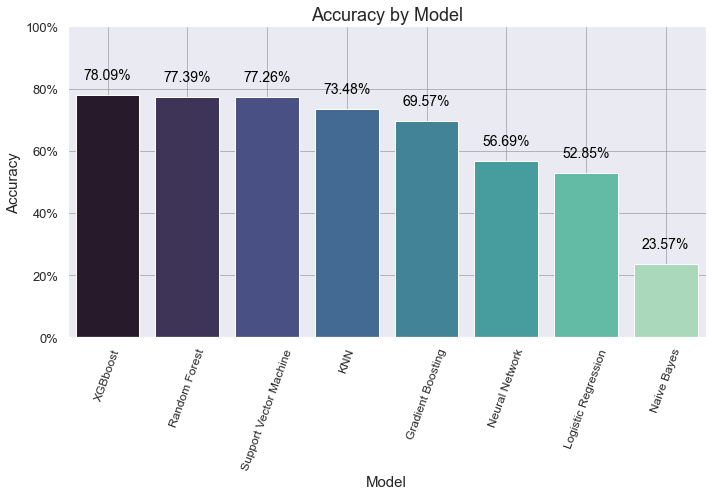

In [1559]:
order = list(df_accuracy.sort_values('Accuracy', ascending=False).Model)
df_accuracy = df_accuracy.sort_values('Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(10,7))
# make barplot and sort bars
x = sns.barplot(x='Model', y="Accuracy", data=df_accuracy, order = order, palette="mako")
plt.xlabel("Model", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Accuracy by Model", fontsize=18)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_accuracy.loc[i, 'Accuracy'] + 0.05, s = str(round((df_accuracy.loc[i, 'Accuracy'])*100, 2))+'%', 
             fontsize = 14, color='black',horizontalalignment='center')

#y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticklabels()]
#ax.set_yticklabels(y_value)

plt.tight_layout()

We see that Random Forest and XGBoost both score pretty close. Both have achieved a very high accuracy given that we have 4 different classes. 

However, we will work on fine-tuning XGBoost further to increase the performance even more. We will use a cross-validation approach and we will follow similar steps to <a href=https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f>this</a> tutorial. 

First we load the train and test data into DMatrices. DMatrix is a data structure used by XGBoost to optimize both memory efficiency and training speed. We will fine tune the baseline XGBoost classifier model and try to better the performance.

In [1560]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

**Params Dictionary**

Dictionary of parameters from the previous XGBoost Model.

In [1561]:
params = XGB_model.get_xgb_params()

In [1562]:
params

{'objective': 'multi:softmax',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'num_class': 10}

For a Multi-class classification problem such as this one, we will typically use "merror", which is a "Multi-class classification error rate" under "eval_metric" which is one of the Learning Task parameters.

Reference: <a href=https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/> Reference Note on XGBoost Tuning</a>

We will also use the "num_boost_round" parameter, which corresponds to the max number of boosting rounds that we will allow. We set it to a large value hoping to find the optimal number of rounds before reaching it, if we haven't improved performance on our test dataset.

In order to automatically find the best number of boosting rounds, we need to pass extra parameters on top of the params dictionary, the training DMatrix and num_boost_round.

In [1563]:
params['eval_metric'] = "merror"
num_boost_round = 1000

In [1564]:
model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, 'Test')], early_stopping_rounds=50, verbose_eval=30)
print("Best merror: {:.2f} with {} rounds".format(model.best_score, model.best_iteration+1))


[0]	Test-merror:0.36963
[30]	Test-merror:0.24023
[60]	Test-merror:0.22293
[90]	Test-merror:0.22229
[120]	Test-merror:0.22422
[148]	Test-merror:0.22422
Best merror: 0.22 with 99 rounds


**Using XGBoost's CV**

To fine-tune the hyperparameters, we will use CV function of XGBoost; we will use a K = 5 for every parameter to run a cross-validation on our training dataset and returns a mean "merror" score.

In [1565]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'merror'},
    early_stopping_rounds=50,
    verbose_eval=30
)
cv_results.tail()

[0]	train-merror:0.31987+0.00718	test-merror:0.38982+0.01725
[30]	train-merror:0.12504+0.00328	test-merror:0.25929+0.01593
[60]	train-merror:0.10214+0.00226	test-merror:0.24632+0.00974
[90]	train-merror:0.09910+0.00191	test-merror:0.24568+0.01197
[120]	train-merror:0.09845+0.00209	test-merror:0.24167+0.01146
[150]	train-merror:0.09829+0.00205	test-merror:0.24471+0.01273
[173]	train-merror:0.09829+0.00205	test-merror:0.24327+0.01117


,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
120,0.098454,0.002088,0.241671,0.011456
121,0.098454,0.002088,0.241672,0.010819
122,0.098454,0.002088,0.241191,0.012096
123,0.098454,0.002088,0.241671,0.013919
124,0.098414,0.002108,0.241031,0.013259


cv returns a table where the rows correspond to the number of boosting trees used. We stopped after about 173 rounds.

The 4 columns correspond to the "mean and standard deviation of "merror" on the test dataset and on the train dataset. We will try to improve the mean test error. We get the best merror from CV with the below:

In [1566]:
cv_results['test-merror-mean'].min()


0.2410306450288436

We are ready to start tuning - first tune our parameters to minimize the "merror" on cross-validation, and then check the performance of our model on the test dataset.

**Parameters max_depth and min_child_weight**

In [1567]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,12)
    for min_child_weight in range(5,8)
]

In [1568]:
# Define initial best params and MAE
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=50,
        verbose_eval=False

    )
    # Update best merror
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, merror: {}".format(best_params[0], best_params[1], min_merror))

CV with max_depth=5, min_child_weight=5
	MAE 0.24119141467019772 for 211 rounds
CV with max_depth=5, min_child_weight=6
	MAE 0.2379874412350393 for 157 rounds
CV with max_depth=5, min_child_weight=7
	MAE 0.24038961938781794 for 130 rounds
CV with max_depth=6, min_child_weight=5
	MAE 0.24087128677300815 for 92 rounds
CV with max_depth=6, min_child_weight=6
	MAE 0.24311192543778612 for 207 rounds
CV with max_depth=6, min_child_weight=7
	MAE 0.24199192687483323 for 133 rounds
CV with max_depth=7, min_child_weight=5
	MAE 0.24311192543778612 for 53 rounds
CV with max_depth=7, min_child_weight=6
	MAE 0.2456750015396933 for 47 rounds
CV with max_depth=7, min_child_weight=7
	MAE 0.23910859456796207 for 181 rounds
CV with max_depth=8, min_child_weight=5
	MAE 0.24038961938781794 for 68 rounds
CV with max_depth=8, min_child_weight=6
	MAE 0.23910872287573648 for 63 rounds
CV with max_depth=8, min_child_weight=7
	MAE 0.2368674426720864 for 134 rounds
CV with max_depth=9, min_child_weight=5
	MAE 0.2

We get the best score with a "max_depth" of 11 and "min_child_weight" of 7. We will update the "params" dictionary accordingly.

In [1569]:
params['max_depth'] = 11
params['min_child_weight'] = 7

**Parameters subsample and colsample_bytree**

Those parameters control the sampling of the dataset that is done at each boosting round.

In [1570]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

# Define initial best params and merror
min_merror = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    # Update best MAE
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (subsample,colsample)
print("Best params: {}, {}, merror: {}".format(best_params[0], best_params[1], min_merror))

CV with subsample=1.0, colsample=1.0
	MAE 0.24055000410584876 for 27 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.24279243907946868 for 29 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.2405507739524953 for 50 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.24103102995216683 for 44 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.24631487241074912 for 26 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.24183192708012563 for 28 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.2429535936441461 for 28 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.24215346636283383 for 21 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.24455423313009378 for 46 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.2435924380530065 for 34 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.23991141631253723 for 33 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.2427920541561454 for 33 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.2423117981564739 for 49 rounds
CV with subsample

We update the params dictionary accordingly.

In [1571]:
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

**Parameter ETA**

The ETA parameter controls the learning rate. It defines the amount of "correction" we make at each step; lower the "eta", more robust it makes our model, but the trade off is in increasing the number of boosting rounds and hence more time to train.

In [1572]:
%time
# This can take some time…
min_merror = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['merror'], early_stopping_rounds=10)

    # Update best score
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = eta

print("Best params: {}, merror: {}".format(best_params, min_merror))


CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 14.1 µs
CV with eta=0.3
CPU times: user 41 s, sys: 3.45 s, total: 44.5 s
Wall time: 5.9 s
	MAE 0.23991141631253723 for 33 rounds

CV with eta=0.2
CPU times: user 43.1 s, sys: 3.92 s, total: 47 s
Wall time: 6.71 s
	MAE 0.23991141631253723 for 33 rounds

CV with eta=0.1
CPU times: user 41.4 s, sys: 3.62 s, total: 45 s
Wall time: 6.08 s
	MAE 0.23991141631253723 for 33 rounds

CV with eta=0.05
CPU times: user 41 s, sys: 3.49 s, total: 44.5 s
Wall time: 5.84 s
	MAE 0.23991141631253723 for 33 rounds

CV with eta=0.01
CPU times: user 41.2 s, sys: 3.45 s, total: 44.7 s
Wall time: 5.96 s
	MAE 0.23991141631253723 for 33 rounds

CV with eta=0.005
CPU times: user 41.1 s, sys: 3.35 s, total: 44.4 s
Wall time: 5.77 s
	MAE 0.23991141631253723 for 33 rounds

Best params: 0.3, merror: 0.23991141631253723


In [1573]:
params['eta'] = 0.3


**Results**

Final parameters of the tuned model:

In [1574]:
params


{'objective': 'multi:softmax',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'merror',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 11,
 'max_leaves': 0,
 'min_child_weight': 7,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'num_class': 10,
 'eta': 0.3}

We will now train a model with these params and see if it improves the performance metrics.

In [1575]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=1000,
    verbose_eval=100
)


[0]	Test-merror:0.35810
[100]	Test-merror:0.23062
[200]	Test-merror:0.22870
[300]	Test-merror:0.23190
[400]	Test-merror:0.23382
[500]	Test-merror:0.23639
[600]	Test-merror:0.22806
[700]	Test-merror:0.23254
[800]	Test-merror:0.23382
[900]	Test-merror:0.23639
[999]	Test-merror:0.22614


In [1576]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    verbose_eval=100,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-merror:0.35810
[100]	Test-merror:0.23062
[200]	Test-merror:0.22870
[300]	Test-merror:0.23190
[400]	Test-merror:0.23382
[500]	Test-merror:0.23639
[519]	Test-merror:0.21845


In [1577]:
metrics.accuracy_score(best_model.predict(dtest), y_test)

0.7815502882767457

The original accuracy was 0.7809 and with this tuning we get a marginal improvement to 0.7815, but nothing very significant.

**Confusion Matrix**

We will come to the final stages of the model and analysis and look at whether our model has correctly classified the data.

In [1578]:
cm_matrix = confusion_matrix(y_test, y_pred_XGB)
print(cm_matrix)

[[  1   0   1   0   0   0]
 [  1 433  11  14   0  38]
 [  2  18  16   0   0   2]
 [  0   7   0 408   5 105]
 [  0   0   0  13   9   1]
 [  0  47   0  77   0 352]]


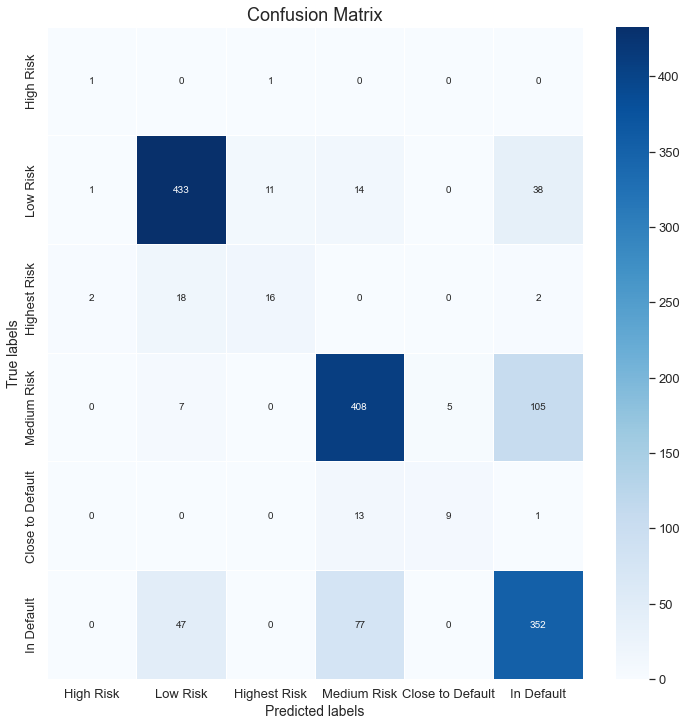

In [1579]:
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(cm_matrix, annot = True, ax = ax, fmt="d", 
            linewidths=.5, linecolor = 'white', cmap="Blues") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['High Risk','Low Risk','Highest Risk','Medium Risk', 'Close to Default', 'In Default'])
ax.yaxis.set_ticklabels(['High Risk','Low Risk','Highest Risk','Medium Risk', 'Close to Default', 'In Default']);

# This part is to correct a bug from the heatmap funciton from pyplot
#b, t = plt.ylim() # discover the values for bottom and top
#b += 0.1 # Add 0.5 to the bottom
#t -= 0.1 # Subtract 0.5 from the top
#plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()


**Normalized Confusion Matrix Heatmap with %-ages**

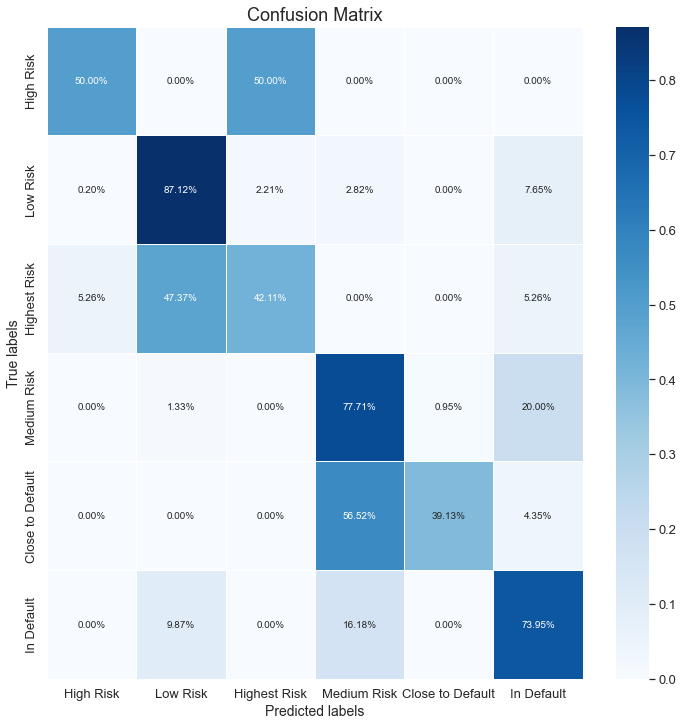

In [1580]:
fig, ax = plt.subplots(figsize=(12,12))

#Create normalized Confusion Matrix
cm_normalized = cm_matrix.astype('float') / cm_matrix.sum(axis=1)[:, np.newaxis]
#sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

sns.heatmap(cm_normalized, annot = True, ax = ax, fmt=".2%", 
            linewidths=.5, linecolor = 'white', cmap="Blues") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['High Risk','Low Risk','Highest Risk','Medium Risk', 'Close to Default', 'In Default'])
ax.yaxis.set_ticklabels(['High Risk','Low Risk','Highest Risk','Medium Risk', 'Close to Default', 'In Default']);

plt.show()


In [1581]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """ 
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


Confusion matrix, without normalization
[[  1   0   1   0   0   0]
 [  1 433  11  14   0  38]
 [  2  18  16   0   0   2]
 [  0   7   0 408   5 105]
 [  0   0   0  13   9   1]
 [  0  47   0  77   0 352]]


/var/folders/jq/9pvkyf4n2b7crtzvgqdbjz7m0000gn/T/ipykernel_28859/3919488224.py:7: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



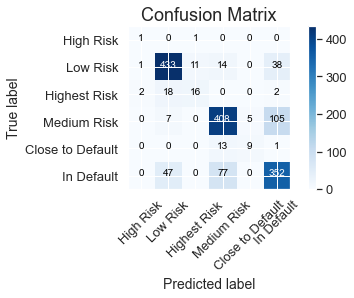

In [1582]:
import itertools
cm_plot_labels = ['High Risk','Low Risk','Highest Risk','Medium Risk', 'Close to Default', 'In Default']

plot_confusion_matrix(cm=cm_matrix, classes=cm_plot_labels, title="Confusion Matrix")


In [1583]:
print("\033[1m The result is telling us that we have: ", (cm[0,0] + cm[1,1] + cm[2,2] + cm[3,3] + cm[4,4] + cm[5,5] + cm[6,6] + cm[7,7] + cm[8,8] + cm[9,9] ),"correct predictions.")
print("\033[1m The result is telling us that we have: ", (cm.sum() - (cm[0,0] + cm[1,1] + cm[2,2] + 
 cm[3,3] + cm[4,4] + cm[5,5] + cm[6,6] + cm[7,7] + 
 cm[8,8] + cm[9,9])),"incorrect predictions.")
print("\033[1m We have a total predictions of: ", (cm.sum()))

 The result is telling us that we have:  415 correct predictions.
 The result is telling us that we have:  1146 incorrect predictions.
 We have a total predictions of:  1561


In [1584]:
print(classification_report(y_test, y_pred_XGB, 
    target_names = ['High Risk','Low Risk','Highest Risk','Medium Risk', 'Close to Default', 'In Default']))


                  precision    recall  f1-score   support

       High Risk       0.25      0.50      0.33         2
        Low Risk       0.86      0.87      0.86       497
    Highest Risk       0.57      0.42      0.48        38
     Medium Risk       0.80      0.78      0.79       525
Close to Default       0.64      0.39      0.49        23
      In Default       0.71      0.74      0.72       476

        accuracy                           0.78      1561
       macro avg       0.64      0.62      0.61      1561
    weighted avg       0.78      0.78      0.78      1561



**Interpretation of the Confusion matrix as a result of our Model**

1. Medium Risk and Low Risk labels were almost correctly classified (maybe also because they were the most labeled, it enhanced the classification)

2. ~ 55% of the "Close to Default" labeled cases have been predicted as "Medium Risk"; those companies can stand to get a better rating

3. ~47% of the cases labeled as "Highest Risk" are predicted as "Low Risk"; money on the table being lost by the banks

4. A small %, but about 20% of "Medium Risk" rated companies have been predicted to be "In Default"; this is a loss to the bank and will be a critical metric that they would track

Considering a high proportion of "Medium Risk" and "Low Risk" labels, we have achieved a high Precision score; Interestingly, it has thrown a high Precision and Recall scores for "Close to Default" cases, indicating they have been correctly classified. In all, we seem to have achieved high accuracy score across categories.

**Feature Selection**

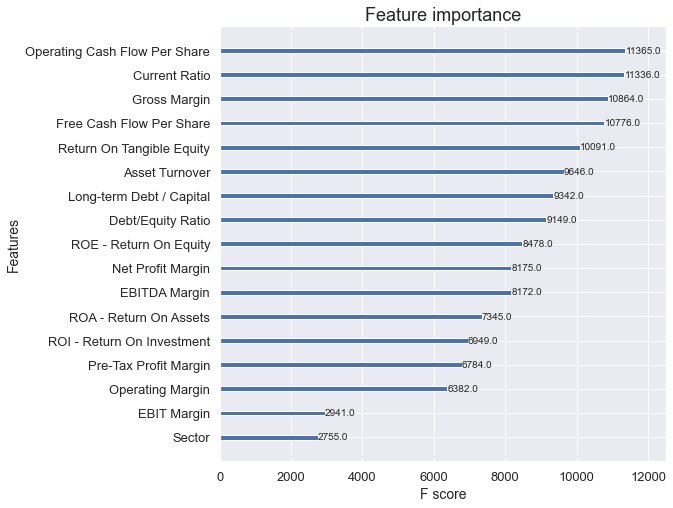

In [1585]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(8, 8))
# xgboost.plot_importance(..., ax=ax)

plot_importance(model, ax=ax)
plt.show()